In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
# import geopandas as gpd
import numpy as np
from time import time
from geopy.distance import geodesic
%matplotlib widget
from scipy.spatial import Delaunay
import random

## biblioteca de modelos
from itertools import product
from logging import raiseExceptions
from sklearn.metrics import roc_auc_score, roc_curve,  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline


In [2]:
dados = pd.read_csv("ocorrencias.csv")
data = dados[dados.columns[[0,1,5,13,-2]]]
data.dropna(inplace=True)
fatores = data.drop(["ocorrências"],axis=1)
target = data[["ocorrências"]].replace({2:1})
target.value_counts()

ocorrências
0              954
1              298
Name: count, dtype: int64

#### Ajustes

### Todos os dados

In [3]:
model = LogisticRegression(class_weight='balanced',max_iter=100000)
pipe = Pipeline([('escala',StandardScaler()),('modelo',model)])
pipe.fit(fatores,target)
y_pred = pipe.predict_proba(fatores)[:,1]

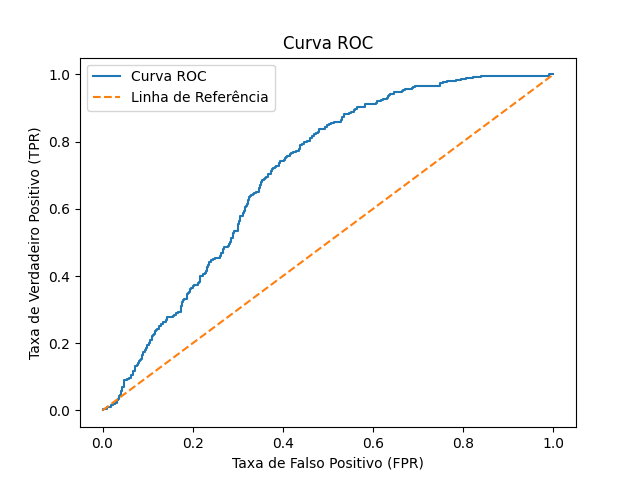

In [67]:
fpr, tpr, thresholds = roc_curve(target, y_pred)
fig,ax = plt.subplots()

# Plotar a curva ROC
ax.plot(fpr, tpr, label='Curva ROC')
ax.plot([0, 1], [0, 1], linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [69]:
coeficientes = pipe.named_steps["modelo"].coef_[0]
coeficientes

array([-0.84371911, -0.28055091,  1.4178717 ,  1.29783489])

In [70]:
fatores.columns

Index(['precipitação', 'pressão', 'temperatura BS', 'umidade relativa '], dtype='object')

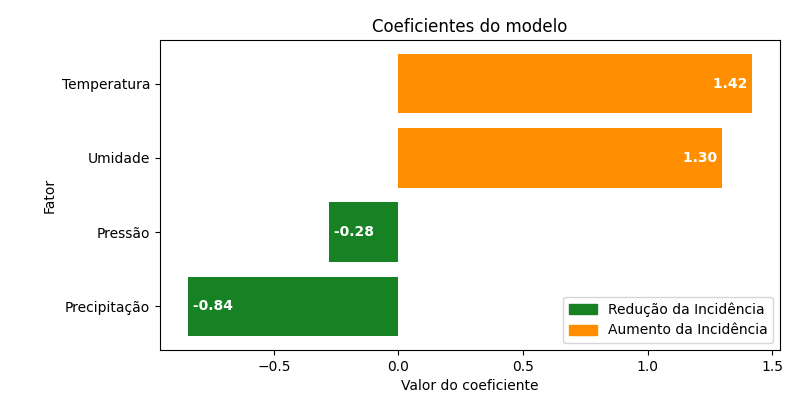

In [11]:
# coeficientes = pipe.named_steps["modelo"].coef_[0]
import matplotlib.patches as mpatches

coeficientes = [-0.84371911, -0.28055091, 1.29783489,1.4178717]
amarelo='#FF8F00'
verde = '#168224'

cores = [amarelo if coef > 0 else verde for coef in coeficientes]
# cores = ['blue' if coef > 0 else 'red' for coef in coeficientes]

# Criando o gráfico de barras
fig,ax = plt.subplots(figsize=(8,4))
left, bottom, width, height = 0.2, 0.125, 0.775, 0.775
ax.set_position([left, bottom, width, height])
ax.barh(range(len(coeficientes)), coeficientes, color=cores)

# Adicionando título e rótulos
# plt.title('Coeficientes')
plt.ylabel('Fator',fontsize=10)
plt.xlabel('Valor do coeficiente',fontsize=10)

labels_x = [f'{x.split(" ")[0][:4]} {x.split(" ")[1][:3]}' if len(x.split(" ")) >2 else f'{x[:4]} ' for x in fatores.columns.to_list()]

ax.set_yticks(range(len(labels_x)))
# ax.set_yticklabels(labels_x)
ax.set_yticklabels(['Precipitação', 'Pressão','Umidade', 'Temperatura'],fontsize=10)

for i, coef in enumerate(coeficientes):
    if coef<0: 
        lado = 'left'
    else:
        lado='right'

    plt.text(coef, i, f' {coef:.2f} ', ha=lado, va='center',fontsize=10, color='white', weight='bold')
patch1 = mpatches.Patch(color=verde, label='Redução da Incidência')
patch2 = mpatches.Patch(color=amarelo, label='Aumento da Incidência')
plt.legend(handles=[patch1, patch2], loc='lower right')
# Exibindo o gráfico
ax.set_title('Coeficientes do modelo')
plt.show()

### Com train test split

In [ ]:
model = LogisticRegression(class_weight='balanced',max_iter=100000)
pipe = Pipeline([('escala',StandardScaler()),('modelo',model)])
X_train,X_test,y_train,y_test = train_test_split(fatores,target,test_size=0.3,stratify=target)
pipe.fit(X_train,y_train)
y_pred = pipe.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(target, y_pred)
fig,ax = plt.subplots()

# Plotar a curva ROC
ax.plot(fpr, tpr, label='Curva ROC')
ax.plot([0, 1], [0, 1], linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
coeficientes = pipe.named_steps["modelo"].coef_[0]
cores = ['blue' if coef > 0 else 'red' for coef in coeficientes]

# Criando o gráfico de barras
fig,ax = plt.subplots()
ax.barh(range(len(coeficientes)), coeficientes, color=cores)

# Adicionando título e rótulos
# plt.title('Coeficientes')
plt.ylabel('Fatores')
plt.xlabel('Valor do Coeficiente')

labels_x = [f'{x.split(" ")[0][:4]} {x.split(" ")[1][:3]}' if len(x.split(" ")) >2 else f'{x[:4]} ' for x in fatores.columns.to_list()]

ax.set_yticks(range(len(labels_x)))
# ax.set_yticklabels(labels_x)
ax.set_yticklabels(['Precipitação', 'Pressão','Temperatura','Umidade'])

for i, coef in enumerate(coeficientes):
    if coef<0: 
        lado = 'left'
    else:
        lado='right'

    plt.text(coef, i, f'{coef:.2f}', ha=lado, va='center',fontsize=10, color='white', weight='bold')

# Exibindo o gráfico
plt.show()

### Com simulação de train test split

In [ ]:
scores = []
coefs = []
model = LogisticRegression(class_weight='balanced',max_iter=100000)
pipe = Pipeline([('escala',StandardScaler()),('modelo',model)])
for i in range(100):
    X_train,X_test,y_train,y_test = train_test_split(fatores,target,test_size=0.3,stratify=target)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test,y_pred))
    coefs.append(pipe.named_steps["modelo"].coef_)


In [ ]:
fig,ax = plt.subplots()
ax.hist(scores)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots()

# Plotar a curva ROC
ax.plot(fpr, tpr, label='Curva ROC')
ax.plot([0, 1], [0, 1], linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
matriz = np.concatenate(coefs, axis=0)
# media_colunas = 
coeficientes = np.mean(matriz, axis=0)

amarelo='#FF8F00'
verde = '#168224'

cores = [amarelo if coef > 0 else verde for coef in coeficientes]

# Criando o gráfico de barras
fig,ax = plt.subplots()
ax.barh(range(len(coeficientes)), coeficientes, color=cores)

# Adicionando título e rótulos
# plt.title('Coeficientes')
plt.ylabel('Fatores')
plt.xlabel('Valor do Coeficiente')

labels_x = [f'{x.split(" ")[0][:4]} {x.split(" ")[1][:3]}' if len(x.split(" ")) >2 else f'{x[:4]} ' for x in fatores.columns.to_list()]

ax.set_yticks(range(len(labels_x)))
# ax.set_yticklabels(labels_x)
ax.set_yticklabels(['Precipitação', 'Pressão','Temperatura','Umidade'])

for i, coef in enumerate(coeficientes):
    if coef<0: 
        lado = 'left'
    else:
        lado='right'

    plt.text(coef, i, f'{coef:.2f}', ha=lado, va='center',fontsize=10, color='white', weight='bold')

# Exibindo o gráfico
plt.show()

In [ ]:
fig,ax = plt.subplots()
pd.DataFrame(matriz).boxplot(ax=ax)
plt.plot()

### Transformando em Regressão linear

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(fatores,target,test_size=0.3,stratify=target)

medias_colunas_df1 = []
medias_colunas_df2 = []

for _ in range(10000):
    indices_amostra = X_train.index.tolist()
    amostra_indices = pd.Series(indices_amostra).sample(n=int(0.5*len(indices_amostra)),replace=True)
    media_amostra_df1 = X_train.loc[amostra_indices].mean(axis=0)
    media_amostra_df2 = y_train.loc[amostra_indices].mean(axis=0)
    medias_colunas_df1.append(media_amostra_df1)
    medias_colunas_df2.append(media_amostra_df2)

medias_df1 = pd.DataFrame(medias_colunas_df1)
medias_df2 = pd.DataFrame(medias_colunas_df2)

In [ ]:
lin = LinearRegression()
lin_pipe = Pipeline([('escala',StandardScaler()),('modelo',lin)])
pipe.fit(medias_df1,medias_df2)
y_score = lin_pipe.predict(X_test)
y_score = [v[0] for v in y_score]
y_pred = [np.exp(x)/(1+np.exp(x)) for x in y_score]
roc_auc_score(y_test,y_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots()

# Plotar a curva ROC
ax.plot(fpr, tpr, label='Curva ROC')
ax.plot([0, 1], [0, 1], linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
log = LogisticRegression(class_weight='balanced',max_iter=100000)
log_pipe = Pipeline([('escala',StandardScaler()),('modelo',log)])
log_pipe.fit(X_train,y_train)
y_pred2 = log_pipe.predict_proba(X_test)[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
fig,ax = plt.subplots()

# Plotar a curva ROC
ax.plot(fpr, tpr, label='Curva ROC')
ax.plot([0, 1], [0, 1], linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [12]:
dados = pd.read_csv("ocorrencias.csv")
data = dados[dados.columns[[0,1,5,13,-2]]]
data.dropna(inplace=True)
fatores = data.drop(["ocorrências"],axis=1)
target = data[["ocorrências"]].replace({2:1})
target.value_counts()

ocorrências
0              954
1              298
Name: count, dtype: int64

In [13]:
g = dados.groupby("município")

In [14]:
muns = list(dados["município"].unique())

In [15]:
vmedio = pd.DataFrame()
variavel = 'temperatura BS'
for mun in muns:
    aux = g.get_group(mun)[variavel]/g.get_group(mun)[variavel].mean()
    vmedio[mun] = list(aux)



In [16]:
umedio = pd.DataFrame()
variavel = 'umidade relativa '
for mun in muns:
    aux = g.get_group(mun)[variavel]/g.get_group(mun)[variavel].mean()
    umedio[mun] = list(aux)

In [17]:
pressaomedio = pd.DataFrame()
variavel = 'pressão'
for mun in muns:
    aux = g.get_group(mun)[variavel]/g.get_group(mun)[variavel].mean()
    pressaomedio[mun] = list(aux)

In [18]:
precipitacaomedio = pd.DataFrame()
variavel = 'precipitação'
for mun in muns:
    aux = g.get_group(mun)[variavel]/g.get_group(mun)[variavel].mean()
    precipitacaomedio[mun] = list(aux)

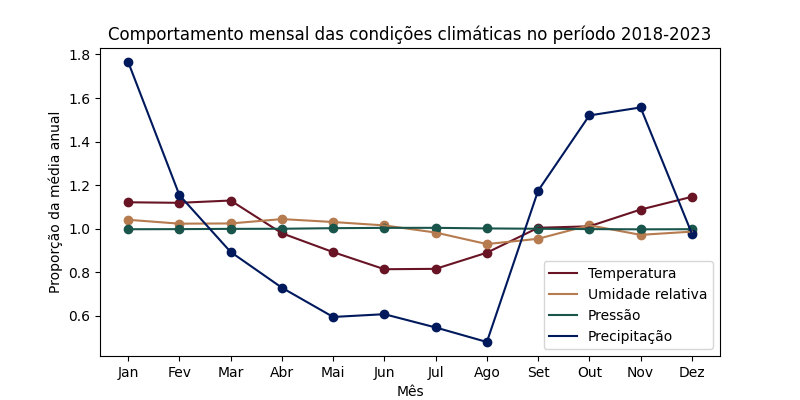

In [23]:
x = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
fig,ax = plt.subplots(figsize = (8,4))
cor1 = '#681425'
ax.scatter(x = x,y=vmedio.mean(axis=1),color = cor1)
ax.plot(x,vmedio.mean(axis=1),color = cor1,label='Temperatura')

cor2 = '#b67b4f'
ax.scatter(x = x,y=umedio.mean(axis=1),color = cor2)
ax.plot(x,umedio.mean(axis=1),color = cor2,label='Umidade relativa')

cor3 = '#1a554c'
ax.scatter(x = x,y=pressaomedio.mean(axis=1),color = cor3)
ax.plot(x,pressaomedio.mean(axis=1),color = cor3,label='Pressão')

cor4 = '#00195c'
ax.scatter(x = x,y=precipitacaomedio.mean(axis=1),color = cor4)
ax.plot(x,precipitacaomedio.mean(axis=1),color = cor4,label='Precipitação')

ax.set_title('Comportamento mensal das condições climáticas no período 2018-2023')
plt.xlabel('Mês')
plt.ylabel('Proporção da média anual')

ax.legend()
plt.show()

In [55]:
plt.close()